In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import time
import random
import tensorflow as tf
print(f"Tensorflow version: {tf.__version__}")
from tensorboard import notebook
from model import Model
from sde_euler import sde_euler
from tf_sde_euler import tf_sde_euler
%load_ext tensorboard

import os
os.environ["XLA_FLAGS"] = "--xla_gpu_cuda_data_dir=C:/Users/Harry/miniconda3/envs/tf/Library/bin"

np.random.seed(1)

Tensorflow version: 2.10.0


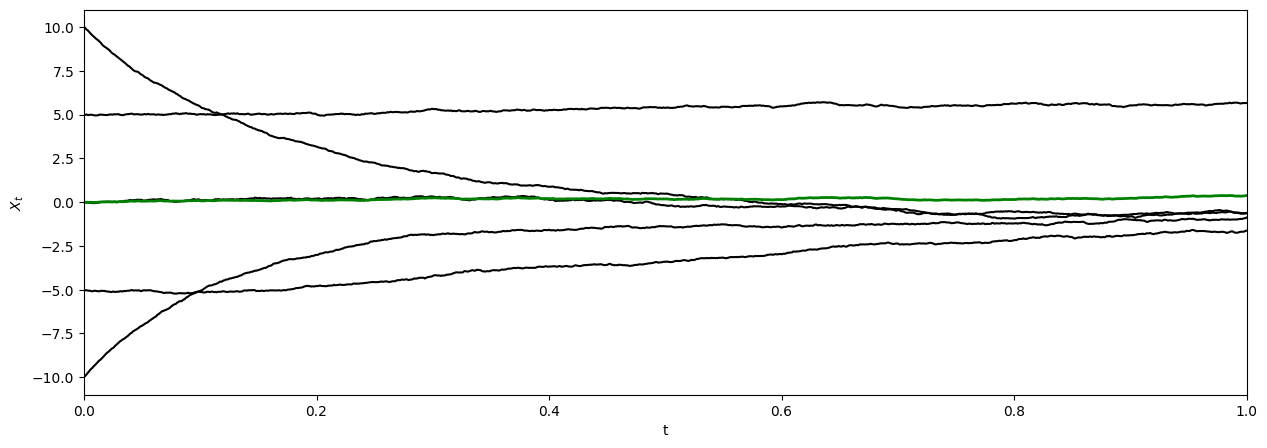

tf.Tensor(
[[1. 0. 1. 0. 1.]
 [0. 1. 0. 0. 0.]
 [1. 0. 1. 0. 1.]
 [0. 0. 0. 1. 1.]
 [1. 0. 1. 1. 1.]], shape=(5, 5), dtype=float32)


In [5]:
dt = 1e-3
N = 5
alpha = 1
sig = 0.5

# Set up random adjacency matrix
baseline = Model(N=5, dt=1e-3, alpha=10, sig=0.5)
obj = baseline
obj.x0 = np.linspace(10, -10, 5)
obj.erdosrenyi(0.3)
obj.network()
obj.simulate()
obj.plot_trajectory()

target_path = obj.x
target_A = tf.cast(obj.A, dtype=tf.float32)
print(target_A)

In [6]:
# Training data parameters
time_window = 2
sample_size = target_path.shape[0] - time_window # 1000-2

# Neural network architecture parameters
num_input_nodes = time_window*N # time-window*N
num_output_nodes = N**2

In [7]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(40, activation='ReLU', input_shape=(num_input_nodes,), kernel_initializer=tf.keras.initializers.GlorotNormal),
    tf.keras.layers.Dense(40, activation='ReLU'),
    tf.keras.layers.Dense(num_output_nodes, activation=tf.keras.activations.hard_sigmoid)
])

In [8]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 40)                440       
                                                                 
 dense_1 (Dense)             (None, 40)                1640      
                                                                 
 dense_2 (Dense)             (None, 25)                1025      
                                                                 
Total params: 3,105
Trainable params: 3,105
Non-trainable params: 0
_________________________________________________________________


In [9]:
# Hyper-parameters
lr = 2e-3

# Adam optimizer
optimizer = tf.keras.optimizers.experimental.Adam(learning_rate=lr, amsgrad=True, jit_compile=True)

model.compile(
    optimizer,
    loss=tf.nn.l2_loss
)

In [10]:
A = tf.eye(N, dtype=tf.float32)
A

<tf.Tensor: shape=(5, 5), dtype=float32, numpy=
array([[1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1.]], dtype=float32)>

In [11]:
# @tf.function
def simulate(A):

    drift = lambda x: (alpha / N) * (tf.tensordot(A, x, axes=1) - x*tf.reduce_sum(A, axis=1))
    diffusion = lambda x: sig

    # Shuffle target data and subsample to generate rolling windows
    idxs = tf.range(tf.shape(target_path)[0]-time_window)
    ridxs = tf.random.shuffle(idxs)[:sample_size]
    
    target_data = []
    for i in ridxs:
        target_data.append(tf.gather(target_path, tf.range(i, i+time_window)))
    target_data = tf.stack(target_data)
    target_data = tf.cast(target_data, dtype = tf.float32)
    init_data = target_data[:, 0, :]

    # Simulate training data from initial data
    train_data = []
    for i in tf.range(sample_size):
        train_data.append(tf_sde_euler(drift, diffusion, (time_window-1)*dt, dt, init_data[i, :]))
    train_data = tf.stack(train_data)

    return train_data, target_data

tf.Tensor(1.5307754, shape=(), dtype=float32)


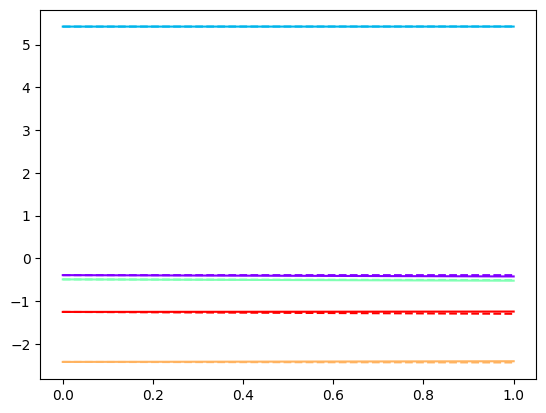

In [12]:
train_data, target_data = simulate(target_A)
print(tf.nn.l2_loss(train_data - target_data))

mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=plt.cm.rainbow(np.linspace(0, 1, N))) 

plt.plot(train_data[1], linestyle='dashed')
plt.plot(target_data[1])
plt.show()

# Training

In [13]:
@tf.function(jit_compile=True)
def init_weights(train_data, target_data):

    with tf.GradientTape() as tape:

        train_data_flat = tf.reshape(train_data, [sample_size, num_input_nodes])
        target_data_flat = tf.reshape(target_data, [sample_size, num_input_nodes])
        A = tf.reduce_mean(model(train_data_flat, target_data_flat), axis=0)
        A = tf.reshape(A, [N, N])

        # Compute loss value
        loss_value = tf.nn.l2_loss(A - tf.eye(N))

    # Use gradient tape to retrieve gradients of trainable variables with respect to loss
    grads = tape.gradient(loss_value, model.trainable_weights)

    # Run one step of gradient descent by updating the value of the variables to minimise the loss
    optimizer.apply_gradients(zip(grads, model.trainable_weights))

    return loss_value, A

In [14]:
# Initialise weights of neural net to output identity matrix
loss_value = 1
while loss_value > 1e-4:
    loss_value, A = init_weights(train_data, target_data)

In [15]:
#@tf.function(jit_compile=True)
def train_step(train_data, target_data):

    with tf.GradientTape() as tape:

        A = tf.reduce_mean(model(train_data, target_data), axis=0)
        A = tf.reshape(A, [N, N])
        
        # Forward pass of the model to get training paths
        train_data, target_data = simulate(A)
        train_data_flat = tf.reshape(train_data, [sample_size, num_input_nodes])
        target_data_flat = tf.reshape(target_data, [sample_size, num_input_nodes])

        # Compute l2 loss value
        loss_value = tf.nn.l2_loss(train_data_flat - target_data_flat) + (tf.linalg.trace(A) - N)**2 + tf.nn.l2_loss(tf.transpose(A) - A)

    # Use gradient tape to retrieve gradients of trainable variables with respect to loss
    grads = tape.gradient(loss_value, model.trainable_weights)

    # Run one step of gradient descent by updating the value of the variables to minimise the loss
    optimizer.apply_gradients(zip(grads, model.trainable_weights))

    return loss_value, A

In [389]:
train_step(tf.reshape(train_data, [sample_size, num_input_nodes]), tf.reshape(target_data, [sample_size, num_input_nodes]))

(<tf.Tensor: shape=(), dtype=float32, numpy=3.7061725>,
 <tf.Tensor: shape=(5, 5), dtype=float32, numpy=
 array([[1.        , 0.        , 1.        , 1.        , 1.        ],
        [0.        , 1.        , 0.0713548 , 0.        , 0.        ],
        [1.        , 0.        , 1.        , 1.        , 0.38595444],
        [0.        , 1.        , 0.75927526, 1.        , 1.        ],
        [1.        , 1.        , 1.        , 1.        , 1.        ]],
       dtype=float32)>)

In [17]:
model(tf.reshape(train_data, [sample_size, num_input_nodes]), tf.reshape(target_data, [sample_size, num_input_nodes]))

<tf.Tensor: shape=(999, 25), dtype=float32, numpy=
array([[1., 0., 0., ..., 0., 0., 1.],
       [1., 0., 0., ..., 0., 0., 1.],
       [1., 0., 0., ..., 0., 0., 1.],
       ...,
       [1., 0., 0., ..., 0., 0., 1.],
       [1., 0., 0., ..., 0., 0., 1.],
       [1., 0., 0., ..., 0., 0., 1.]], dtype=float32)>

In [21]:
data = tf.data.Dataset.from_tensor_slices((
    tf.reshape(train_data, [sample_size, num_input_nodes]),
    tf.reshape(target_data, [sample_size, num_input_nodes])
))

In [16]:
def training_algorithm(A, num_epochs):

    # Initialise metrics to get mean loss per epoch and episode
    epoch_loss_metric = tf.keras.metrics.Mean(name='epoch_loss', dtype=tf.float32)

    # Benchmark training time
    start_time = time.time()

    # Inner loop to train neural net
    for epoch in np.arange(num_epochs):
    
        # Initialize to store average mini-batch loss per epoch
        epoch_loss_metric.reset_states()

        # Generate synthetic training data and flatten
        train_data, target_data = simulate(A)
    
        # Training step
        loss_value, A = train_step(
            train_data = tf.reshape(train_data, [sample_size, num_input_nodes]),
            target_data = tf.reshape(target_data, [sample_size, num_input_nodes])
            )      
                    
        # Update the metrics per epoch
        epoch_loss_metric.update_state(loss_value)
            
        # Get the metric results
        epoch_mean_loss = epoch_loss_metric.result()

        # Summary stats per epoch
        tf.summary.scalar('epoch_loss', epoch_mean_loss, step=epoch)
        if epoch % 2 == 0:
            tf.print(f"Epoch {epoch}: Loss: {epoch_mean_loss:.5f}")

    # Print total training time
    print(f"Training took {time.strftime('%H:%M:%S', time.gmtime(time.time() - start_time))}")

    return A, train_data, target_data

In [ ]:
A_pred, train_data_pred, target_data_pred = training_algorithm(A, 50)

In [ ]:
train_data_pred

In [380]:
np.round(A_pred)

array([[1., 0., 1., 1., 1.],
       [0., 1., 0., 0., 0.],
       [1., 0., 1., 1., 0.],
       [0., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.]], dtype=float32)

In [378]:
obj.A

array([[1., 0., 1., 0., 1.],
       [0., 1., 0., 0., 0.],
       [1., 0., 1., 0., 1.],
       [0., 0., 0., 1., 1.],
       [1., 0., 1., 1., 1.]])

In [232]:
# Deviation of predicted adjacency matrix against actual
tf.nn.l2_loss(A_pred - obj.A)

<tf.Tensor: shape=(), dtype=float32, numpy=4.0>

tf.Tensor(0.020463124, shape=(), dtype=float32)


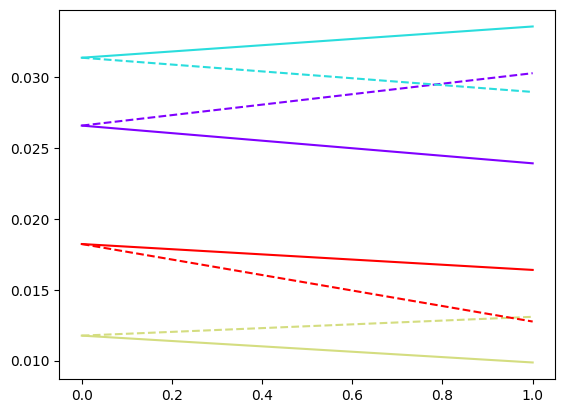

In [233]:
print(tf.nn.l2_loss(train_data_pred - target_data_pred))

mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=plt.cm.rainbow(np.linspace(0, 1, N))) 

plt.plot(train_data_pred[1], linestyle='dashed')
plt.plot(target_data_pred[1])
plt.show()